In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import transforms, models, datasets
import torchvision
import numpy as np
import h5py
from matplotlib import pyplot as plt
from skimage.transform import resize
from Utils import save_large_dataset, load_large_dataset, calculate_metric
plt.ion()   # interactive mode

In [6]:
CUDA = True

In [7]:
X = load_large_dataset('images')
Y = load_large_dataset('labels')

In [8]:
X = X.squeeze() #remove unnecessary dimension
Y = Y.squeeze()

Let's see an example of a "slice" from the 1st dimension

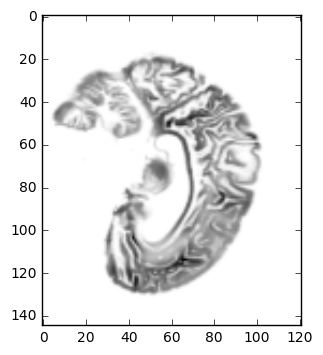

In [44]:
fig = plt.figure(figsize=(4,4))
my_slice = X[0,56,:,:]
plt.imshow(my_slice, cmap="Greys")

In [42]:
start = 12
end = 15
BATCH_SIZE = 32

In [43]:
for k in range(31): #loop over different slices (channels)
    average_val_metric = 0.0
    
    for z in range(10): #loop over 10 different validation set
        X_sliced = X[:,start:end,:,:] #take only 3 slices and treat them as channels
        X_padded = np.pad(X_sliced,((0,0),(0,0),(40,39),(51,52)), 'constant') #pad with zeros to get 224x224 dimension of images
        #X_padded = np.pad(X_sliced,((0,0),(51,52),(0,0),(51,52)), 'constant') #pad with zeros to get 224x224 dimension of images
        X_padded = np.float32(X_padded)
        #X_padded = np.rollaxis(X_padded, 3, 1) #move channel dimension to be the first one

        np.random.seed(z) #seed fixed for reproducibility
        mask = np.random.rand(len(X)) < 0.9  #array of boolean variables

        training_set = X_padded[mask]
        training_labels = Y[mask]

        validation_set = X_padded[~mask]
        validation_labels = Y[~mask]

        training_set = torch.from_numpy(training_set) #convert to torch tensor
        training_labels = torch.from_numpy(training_labels) #convert to torch tensor
        validation_set = torch.from_numpy(validation_set) #convert to torch tensor
        validation_labels = torch.from_numpy(validation_labels) #convert to torch tensor
        training_labels = training_labels.long()
        validation_labels = validation_labels.long()
        dataset = torch.utils.data.TensorDataset(training_set, training_labels)
        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_set = torch.utils.data.TensorDataset(validation_set, validation_labels)
        validation_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

        net = models.vgg11_bn(pretrained=True)
        net.classifier._modules['6'] = nn.Linear(4096, 2)
        #net = models.resnet18(pretrained=True)
        #num_ftrs = net.fc.in_features
        #net.fc = nn.Linear(num_ftrs, 2)

        criterion = nn.CrossEntropyLoss()
        net.cuda()
        optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay=1e-3)


        val_epoch_loss = 0.0
        val_metric = 0.0

        ######## LOOP FOR TRAINING #############

        for epoch in range(2):  

            net.train()
            running_loss = 0.0
            metric_sum = 0.0

            for i, data in enumerate(train_loader, 0):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if (CUDA):
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                metric_sum += calculate_metric(preds,labels.data) * inputs.size(0)

            epoch_loss = running_loss / len(training_set)
            metric = metric_sum / len(training_set)
            #print('{}-{}  Train Loss: {:.4f} Train Metric: {:.4f}'.format(start,end,epoch_loss,metric))


            #VALIDATION
            running_loss = 0.0
            metric_sum = 0.0
            net.eval() #set in the evaluation mode (important for Dropout and Batchnorm)

            for j, val_data in enumerate(validation_loader, 0):
                # get the inputs
                val_inputs, val_labels = val_data

                # wrap them in Variable
                if (CUDA):
                    val_inputs, val_labels = Variable(val_inputs.cuda()), Variable(val_labels.cuda())
                else:
                    val_inputs, val_labels = Variable(val_inputs), Variable(val_labels)

                outputs = net(val_inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, val_labels)

                # statistics
                running_loss += loss.data[0] * val_inputs.size(0)
                metric_sum += calculate_metric(preds,val_labels.data) * val_inputs.size(0)

            val_epoch_loss = running_loss / len(validation_set)
            val_metric = metric_sum / len(validation_set)


        #print('{}-{}  Validation Loss: {:.4f} Validation Metric: {:.4f}'.format(start,end,val_epoch_loss, val_metric))
        average_val_metric += val_metric
    
    average_val_metric /= 10 #calculate average metric out of 10 validation sets
    print('{}-{}  Average validation metric: {:.4f}'.format(start,end,average_val_metric))
    start = start + 3
    end = end + 3

12-15  Average validation metric: 0.5407
15-18  Average validation metric: 0.5919
18-21  Average validation metric: 0.5912
21-24  Average validation metric: 0.6095
24-27  Average validation metric: 0.5440
27-30  Average validation metric: 0.5615
30-33  Average validation metric: 0.5767
33-36  Average validation metric: 0.5771
36-39  Average validation metric: 0.6057
39-42  Average validation metric: 0.6053
42-45  Average validation metric: 0.6075
45-48  Average validation metric: 0.6176
48-51  Average validation metric: 0.5914
51-54  Average validation metric: 0.5865
54-57  Average validation metric: 0.5784
57-60  Average validation metric: 0.6082
60-63  Average validation metric: 0.6047
63-66  Average validation metric: 0.5956
66-69  Average validation metric: 0.5909
69-72  Average validation metric: 0.5981
72-75  Average validation metric: 0.5867
75-78  Average validation metric: 0.6078
78-81  Average validation metric: 0.5983
81-84  Average validation metric: 0.5786
84-87  Average v